In [1]:
import os, sys
sys.path.append("/home/alexanderalbizu")
sys.path.append("/home/alexanderalbizu/.local/bin")
os.environ["WANDB_NOTEBOOK_NAME"] = "CNN_II.ipynb"
#!python setup.py develop 
#!pip install wandb
#!pip install 'monai[all]'
#!pip -q install vit_pytorch
#!pip -q install linformer
#!pip3 install torch==1.9.0+cu111 torchvision==0.10.0+cu111 torchaudio==0.9.0 -f https://download.pytorch.org/whl/torch_stable.html
!pip install git+https://github.com/shijianjian/EfficientNet-PyTorch-3D

Defaulting to user installation because normal site-packages is not writeable
  Cloning https://github.com/shijianjian/EfficientNet-PyTorch-3D to /scratch/local/39254620/pip-req-build-sflh1hvb
  Created wheel for efficientnet-pytorch-3d: filename=efficientnet_pytorch_3d-0.6.3-py3-none-any.whl size=16759 sha256=10c15e1743a65b23c8347cd31853e5b2a7d08d0b3359ac846d2422667e2a28ac
  Stored in directory: /scratch/local/39254620/pip-ephem-wheel-cache-hepvllok/wheels/71/7b/d7/7845882d34b3ee447d8940f660a12da4c88a077f55c45c73ac
Successfully built efficientnet-pytorch-3d


In [2]:
import json, glob, random, re, collections, time, cv2, torch

import numpy as np
import wandb as wb
import pandas as pd
import matplotlib.pyplot as plt
import nibabel as nib

from scipy.io import loadmat as lm
from enum import Enum
from torch import nn
from torch.utils import data as torch_data
from sklearn.model_selection import train_test_split
from torch.nn import functional as torch_functional

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
from monai.networks import nets
from monai.data import (
    DataLoader,
    ImageDataset,
    CSVDataset,
)
from monai.transforms import (
    AddChannel,
    Compose,
    RandGaussianNoise,
    Resize,
    RemoveRepeatedChannel,
    Orientation,
    RandRotate90,
    RandBiasField,
    ScaleIntensity,
    ToDevice,
    EnsureType,
)
from efficientnet_pytorch_3d import EfficientNet3D
wb.login(); # 7e5f63e5846f29b034d98806712ab047df76834d

wandb: Currently logged in as: aalbizu. Use `wandb login --relogin` to force relogin


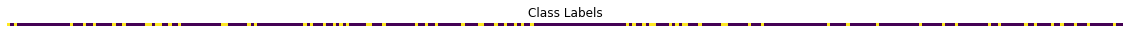

In [3]:
# Set data directory
rootDir = '/blue/camctrp/working/gullettj/ACT/derivatives/SVM/';
sdata = pd.read_csv(os.path.join(rootDir,'subjects_pre-mci_classification.csv')).to_numpy();
mri_types = ['T1', 'EPI']
IM_SIZE = (64,64,64)
PAT_SIZE = (16,16,16)
BATCH_SIZE = 4
N_EPOCHS = 5
SEED = 42
LEARNING_RATE = 0.0005
LR_DECAY = 0.9
samples_to_exclude = np.array([103744,106986,300142,101644,105903,106078,106817,101395,105554,204085])
exclude = np.equal(np.isin(sdata[:,0],samples_to_exclude),0);

num_of_cores = int(os.environ['SLURM_CPUS_PER_TASK'])

# Two binary labels for Healthy vs pre-MCI
subIdx = np.arange(sdata[exclude,0].shape[0]);
lab = np.array([sdata[:,1]]);
lab = lab[:,exclude]; 
labels = torch.nn.functional.one_hot(torch.as_tensor(lab.T)).float()

# Remove 20ch Head Coils
T1w_images = np.array([os.path.join(rootDir,'anat',''.join(['wc0csub-',str(sdata[s,0]),'_ses-01_T1w.nii'])) for s in range(sdata.shape[0])]);
T1w_images = T1w_images[exclude];
EPI_images = np.array([os.path.join(rootDir,'func',''.join(['sub-',str(sdata[s,0]),'_ROIconnectivity.csv'])) for s in range(sdata.shape[0])]);
EPI_images = EPI_images[exclude];

class Diagnosis(Enum):
    normal = 0
    preMCI = 1

# Plot Labels
plt.rcParams['figure.figsize'] = [20, 20]; plt.imshow(lab); 
plt.axis('off'); plt.title('Class Labels');

T1 Shape: (181, 217, 181) 
CONN Shape: (51, 51)


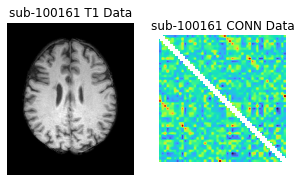

In [4]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    
seed_everything(SEED)    

# Plot OG Images
fig, axes = plt.subplots(*[1,2], figsize=(5, 5), facecolor="white")

# T1w
axes[0].set_title(''.join(['sub-',str(sdata[0,0]),' T1 Data']));
nii = nib.load(T1w_images[0]); # Load Each Electrode
axes[0].imshow(nii.get_fdata()[:, :, 100].T, cmap="gray", origin="lower"); axes[0].axis('off'); 
# EPI
axes[1].set_title(''.join(['sub-',str(sdata[0,0]),' CONN Data']));
mat = pd.read_csv(EPI_images[0],delimiter=',',header=None); # Load Each Electrode
axes[1].imshow(mat, cmap="turbo"); axes[1].axis('off');
print('T1 Shape:',nii.shape,'\nCONN Shape:',mat.shape)

In [5]:
class Trainer:
    def __init__(
        self, 
        model, 
        device, 
        optimizer, 
        criterion
    ):
        self.model = model
        self.device = device
        self.optimizer = optimizer
        self.lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(self.optimizer, gamma=LR_DECAY)
        self.criterion = criterion

        self.best_valid_score = 0.0
        self.n_patience = 0
        self.lastmodel = None
        
        self.val_losses = []
        self.train_losses = []
        self.val_auc = []
        
        wb.init(project="ACT-CNN",
           config={
               "batch_size": BATCH_SIZE,
               "image_size": IM_SIZE,
               "learning_rate": LEARNING_RATE,
               "dataset": "ACT",
           })
        wb.watch(model, log='all')
        
    def fit(self, epochs, train_loader, valid_loader, save_path, patience):      
        for n_epoch in range(1, epochs + 1):
            self.info_message("EPOCH: {}", n_epoch)
            
            train_loss, train_time = self.train_epoch(train_loader)
            valid_loss, valid_auc, valid_time = self.valid_epoch(valid_loader)
            
            self.train_losses.append(train_loss)
            self.val_losses.append(valid_loss)
            self.val_auc.append(valid_auc)
            
            self.info_message(
                "[Epoch Train: {}] loss: {:.4f}, time: {:.2f} s",
                n_epoch, train_loss, train_time
            )
            
            self.info_message(
                "[Epoch Valid: {}] loss: {:.4f}, auc: {:.4f}, time: {:.2f} s",
                n_epoch, valid_loss, valid_auc, valid_time
            )

            if self.best_valid_score < valid_auc: 
                self.save_model(n_epoch, save_path, valid_loss, valid_auc)
                self.info_message(
                     "auc improved from {:.4f} to {:.4f}. Saved model to '{}'", 
                    self.best_valid_score, valid_auc, self.lastmodel
                )
                self.best_valid_score = valid_auc
                self.n_patience = 0
            else:
                self.n_patience += 1
            
            if self.n_patience >= patience:
                self.info_message("\nValid auc didn't improve last {} epochs.", patience)
                break
            
    def train_epoch(self, train_loader):
        self.model.train()
        t = time.time()
        sum_loss = 0

        for step, batch in enumerate(train_loader, 1):
            X = batch[0].clone().float().to(self.device)
            targets = batch[1].to(self.device)
            self.optimizer.zero_grad()
            outputs = self.model(X).squeeze(1)
            loss = self.criterion(outputs, targets.float())
            acc = (outputs.argmax(dim=0) == targets.argmax(dim=0)).float().mean()
            wb.log({'train_loss': loss, 'train_acc': acc})
            
            loss.backward()

            sum_loss += loss.detach().item()
            
            self.optimizer.step()
            
            message = 'Train Step {}/{}, train_loss: {:.4f}'
            self.info_message(message, step, len(train_loader), sum_loss/step, end="\r")
            
        self.lr_scheduler.step()
        
        return sum_loss/len(train_loader), int(time.time() - t)
    
    def valid_epoch(self, valid_loader):
        self.model.eval()
        t = time.time()
        sum_loss = 0
        y_all = []
        outputs_all = []

        for step, batch in enumerate(valid_loader, 1):
            with torch.no_grad():
                targets = batch[1].to(self.device)

                output = self.model(batch[0].clone().detach().float().to(self.device)).squeeze(1)
                loss = self.criterion(output, targets.float())
                sum_loss += loss.detach().item()
                output = torch.sigmoid(output)
                val_acc = (output.argmax(dim=0) == targets.argmax(dim=0)).float().mean()
                wb.log({'val_loss': loss, 'val_acc': val_acc})
                
                y_all.extend(batch[1].tolist())
                outputs_all.extend(output.tolist())

            message = 'Valid Step {}/{}, valid_loss: {:.4f}'
            self.info_message(message, step, len(valid_loader), sum_loss/step, end="\r")
            
        auc = roc_auc_score(y_all, outputs_all)
        
        return sum_loss/len(valid_loader), auc, int(time.time() - t)
    
    def save_model(self, n_epoch, save_path, loss, auc):
        self.lastmodel = f"{save_path}-e{n_epoch}-loss{loss:.3f}-auc{auc:.3f}.pth"
        wb.run.log_code("."); wb.finish()
        torch.save(
            {
                "model_state_dict": self.model.state_dict(),
                "optimizer_state_dict": self.optimizer.state_dict(),
                "best_valid_score": self.best_valid_score,
                "n_epoch": n_epoch,
            },
            self.lastmodel,
        )
        
    def display_plots(self, mri_type):
        plt.figure(figsize=(10,5))
        plt.title("{}: Training and Validation Loss")
        plt.plot(self.val_losses,label="val")
        plt.plot(self.train_losses,label="train")
        plt.xlabel("iterations")
        plt.ylabel("Loss")
        plt.legend()
        plt.show()
        plt.close()
        
        plt.figure(figsize=(10,5))
        plt.title("{}: Validation AUC-ROC")
        plt.plot(self.val_auc,label="val")
        plt.xlabel("iterations")
        plt.ylabel("AUC")
        plt.legend()
        plt.show()
        plt.close()
    
    @staticmethod
    def info_message(message, *args, end="\n"):
        print(message.format(*args), end=end)

In [6]:
nontest_list, test_list = train_test_split(subIdx, 
                                          test_size=0.05,
                                          stratify=lab.T,
                                          random_state=SEED)
nontest_label, test_label = train_test_split(lab.T, 
                                          test_size=0.05,
                                          stratify=lab.T,
                                          random_state=SEED)
train_list, valid_list = train_test_split(nontest_list, 
                                          test_size=0.10,
                                          stratify=nontest_label,
                                          random_state=SEED)
train_label, valid_label = train_test_split(nontest_label, 
                                          test_size=0.10,
                                          stratify=nontest_label,
                                          random_state=SEED);
print('train case split: ',sum(train_label)[0],':',len(train_label)-sum(train_label)[0])
print('valid case split: ',sum(valid_label)[0],':',len(valid_label)-sum(valid_label)[0])
print('test case split: ',sum(test_label)[0],':',len(test_label)-sum(test_label)[0],'\n')
del nontest_list, nontest_label; # Save RAM

train case split:  57 : 232
valid case split:  6 : 27
test case split:  3 : 14 



In [7]:
pin_memory = torch.cuda.is_available()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# def build_model():
# #     model = nets.ViTAutoEnc(in_channels=1, img_size=IM_SIZE, patch_size=PAT_SIZE)
#     model = nets.DenseNet121(spatial_dims=3, in_channels=1, out_channels=1)
#     return model  
class build_model():
    def __init__(self):
        super().__init__()
        self.net = EfficientNet3D.from_name("efficientnet-b0", override_params={'num_classes': 2}, in_channels=1)
        n_features = self.net._fc.in_features
        self.net._fc = nn.Linear(in_features=n_features, out_features=1, bias=True)
    
    def forward(self, x):
        out = self.net(x)
        return out

def train_mri_type(df_train, df_valid, train_lab, valid_lab, mri_type):
#     print(df_train.shape, df_valid.shape)
#     display(df_train.head())
#     display(df_valid.head())

    if mri_type == 'T1':
        # Define transforms
        train_transforms = Compose([
        ScaleIntensity(minv=0.0, maxv=1.0),
        AddChannel(),
        Resize(IM_SIZE),
        RandGaussianNoise(), 
        EnsureType(data_type='tensor')]);
        train_ds = ImageDataset(image_files=T1w_images[df_train], labels=train_lab[:,0], transform=train_transforms);
    elif mri_type == 'EPI':
        # Define transforms
        train_transforms = Compose([EnsureType(data_type='tensor')]);
        train_ds = CSVDataset(image_files=EPI_images[df_train], labels=train_lab[:,0], transform=train_transforms);
    train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=num_of_cores, pin_memory=pin_memory);

    # create a validation data loader
    if mri_type == 'T1':
        val_transforms = Compose([
        ScaleIntensity(minv=0.0, maxv=1.0),
        AddChannel(),
        Resize(IM_SIZE),
        EnsureType(data_type='tensor')]);
        valid_ds = ImageDataset(image_files=T1w_images[valid_list], labels=valid_lab[:,0], transform=val_transforms);
    elif mri_type == 'EPI':
        val_transforms = Compose([EnsureType(data_type='tensor')]);
        valid_ds = CSVDataset(image_files=EPI_images[valid_list], labels=valid_lab[:,0], transform=val_transforms);
    valid_loader = DataLoader(valid_ds, batch_size=BATCH_SIZE, num_workers=num_of_cores, pin_memory=pin_memory)

    model = build_model()
    model.to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

    criterion = torch_functional.binary_cross_entropy_with_logits

    trainer = Trainer(
        model, 
        device, 
        optimizer, 
        criterion
    )

    history = trainer.fit(
        N_EPOCHS, 
        train_loader, 
        valid_loader, 
        f"{mri_type}", 
        N_EPOCHS,
    )
    
    trainer.display_plots(mri_type)
    
    return trainer.lastmodel

modelfiles = None

if not modelfiles:
    modelfiles = [train_mri_type(train_list, valid_list, train_label, valid_label, m) for m in mri_types]
    print(modelfiles)

AttributeError: 'build_model' object has no attribute 'to'

In [ ]:
def predict(modelfile, df, mri_type, split):
    print("Predict:", modelfile, mri_type, df.shape)
    
    # create a validation data loader
    if mri_type == 'T1':
        val_transforms = Compose([
        ScaleIntensity(minv=0.0, maxv=1.0),
        AddChannel(),
        Resize(IM_SIZE),
        EnsureType(data_type='tensor')]);
        test_ds = ImageDataset(image_files=T1w_images[test_list], labels=test_label[:,0], transform=val_transforms)
    elif mri_type == 'EPI':
        val_transforms = Compose([EnsureType(data_type='tensor')]);
        test_ds = ImageDataset(image_files=EPI_images[test_list], labels=test_label[:,0], transform=val_transforms)
    test_loader = DataLoader(test_ds, batch_size=test_batch, num_workers=num_of_cores, pin_memory=pin_memory)
   
    model = build_model()
    model.to(device)
    
    checkpoint = torch.load(modelfile)
    model.load_state_dict(checkpoint["model_state_dict"])
    model.eval()
    
    y_pred = []
    ids = []

    for e, batch in enumerate(data_loader,1):
        print(f"{e}/{len(data_loader)}", end="\r")
        with torch.no_grad():
            tmp_pred = torch.sigmoid(model(torch.tensor(batch["X"]).float().to(device)).squeeze(1)).cpu().numpy().squeeze()
            if tmp_pred.size == 1:
                y_pred.append(tmp_pred)
            else:
                y_pred.extend(tmp_pred.tolist())
            ids.extend(batch["id"].numpy().tolist())
            
    preddf = pd.DataFrame({"sub": ids, "pred": y_pred}) 
    preddf = preddf.set_index("pred")
    return preddf

In [ ]:
df_pred = df_valid.set_index("sub")
df_pred["pred"] = 0
for m, mtype in zip(modelfiles,  mri_types):
    pred = predict(m, df_pred, mtype, "train")
    df_pred["pred"] += pred["pred"]
df_pred["pred"] /= len(modelfiles)
auc = roc_auc_score(df_pred["pred"], df_pred["pred"])
print(f"Validation ensemble AUC: {auc:.4f}")
print(df_pred["pred"])